In [108]:
import h5py
import os
import sys
from collections import defaultdict
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm

from genomic_utils.variant import Variant

sys.path += ["../", "../../vcf_utils"]
import evaluation_utils
import utils

In [6]:
TRAIN_H5_PATH = "../../finetuning/data/h5_bins_384_chrom_split/train.h5"
TEST_H5_PATH = "../../finetuning/data/h5_bins_384_chrom_split/test.h5"

GEUVADIS_COUNTS_PATH = (
    "../../process_geuvadis_data/log_tpm/corrected_log_tpm.annot.csv.gz"
)
CONTEXT_SIZE = 128 * 384

FIGURES_DIR = "../figures"

# Helper functions

In [8]:
def get_training_genes():
    gene_to_class_map = evaluation_utils.get_gene_to_class_map()
    train_genes = {g for g, c in gene_to_class_map.items() if c != "unseen"}
    assert len(train_genes) == 400
    return train_genes

In [9]:
def get_samples_per_gene(h5_path: str) -> dict[str, set]:
    samples_per_gene = defaultdict(set)
    with h5py.File(h5_path, "r") as f:
        genes = f["genes"][:].astype(str)
        samples = f["samples"][:].astype(str)
        for (gene, sample) in zip(genes, samples):
            samples_per_gene[gene].add(sample)
    return samples_per_gene

In [13]:
def compute_alternate_allele_frequency(geno_mtx: pd.DataFrame) -> pd.Series:
    ac = geno_mtx.applymap(utils.convert_to_dosage).sum(axis=1)
    an = geno_mtx.applymap(utils.count_total_alleles).sum(axis=1)
    aaf = ac / an
    return aaf

# Find alleles unobserved during training

In [16]:
counts_df = pd.read_csv(GEUVADIS_COUNTS_PATH, index_col="our_gene_name")
training_genes = get_training_genes()
train_samples_per_gene = get_samples_per_gene(TRAIN_H5_PATH)
test_samples_per_gene = get_samples_per_gene(TEST_H5_PATH)

In [76]:
unseen_variants = defaultdict(list)
n_total_alleles_per_gene = defaultdict(int)

for gene in tqdm(training_genes):
    geno_mtx = utils.get_genotype_matrix(
        counts_df.loc[gene, "Chr"], counts_df.loc[gene, "Coord"], CONTEXT_SIZE
    )
    train_samples = sorted(train_samples_per_gene[gene])
    test_samples = sorted(test_samples_per_gene[gene])

    train_aaf = compute_alternate_allele_frequency(geno_mtx[train_samples])
    test_aaf = compute_alternate_allele_frequency(geno_mtx[test_samples])
    comb_aaf = compute_alternate_allele_frequency(
        geno_mtx[train_samples + test_samples]
    )

    # Find alt alleles present in test, but not in train
    seen_train_alt = set(train_aaf[train_aaf > 0].index)
    seen_test_alt = set(test_aaf[test_aaf > 0].index)
    unseen_test_alt = seen_test_alt - seen_train_alt
    for v in unseen_test_alt:
        unseen_variants["gene"].append(gene)
        unseen_variants["variant"].append(v)
        unseen_variants["test_af"].append(test_aaf[v])

    # Find ref alleles present in test, but not in train
    seen_train_ref = set(train_aaf[train_aaf < 1.0].index)
    seen_test_ref = set(test_aaf[test_aaf < 1.0].index)
    unseen_test_ref = seen_test_ref - seen_train_ref
    for v in unseen_test_ref:
        unseen_variants["gene"].append(gene)
        unseen_variants["variant"].append(v.switch_ref_alt())
        unseen_variants["test_af"].append(1 - test_aaf[v])

    # Find the total number of alleles that are contained in this gene
    n_total_alleles_per_gene[gene] += (comb_aaf > 0).sum()  # alt
    n_total_alleles_per_gene[gene] += (comb_aaf < 1).sum()  # ref

  0%|          | 0/400 [00:00<?, ?it/s]

In [77]:
unseen_variants_df = pd.DataFrame(unseen_variants)
unseen_variants_df.head()

,gene,variant,test_af
0,hat1,chr2:172802723 A/G,0.019481
1,hat1,chr2:172799593 C/G,0.084416
2,hat1,chr2:172782390 A/G,0.006494
3,hat1,chr2:172803207 T/C,0.006494
4,hat1,chr2:172779697 G/A,0.103896


# Plot

In [110]:
def plot_results(
    unseen_variants_df: pd.DataFrame,
    n_total_alleles_per_gene: dict[str, int],
    gene_to_class_map: dict[str, str],
    savepath: Optional[str] = None,
):
    fig, axs = plt.subplots(ncols=2, figsize=(12, 5))

    # (A) Plot the KDE of the fraction of unseen variants, stratified by gene class
    unseen_counts = unseen_variants_df.groupby("gene")["variant"].count()
    unseen_counts_df = pd.DataFrame(unseen_counts).rename(
        columns={"variant": "n_unseen"}
    )
    unseen_counts_df["n_total"] = unseen_counts_df.index.map(n_total_alleles_per_gene)
    unseen_counts_df["fraction"] = (
        unseen_counts_df["n_unseen"] / unseen_counts_df["n_total"]
    )
    unseen_counts_df["gene_class"] = unseen_counts_df.index.map(gene_to_class_map)
    unseen_counts_df["gene_class"] = unseen_counts_df["gene_class"].map(
        {"random_split": "Random-split genes", "yri_split": "Population-split genes"}
    )

    sns.kdeplot(
        data=unseen_counts_df,
        x="fraction",
        hue="gene_class",
        hue_order=["Random-split genes", "Population-split genes"],
        common_norm=False,
        cut=0,
        ax=axs[0],
    )
    axs[0].set(
        xlabel="Fraction of alleles",
        ylabel="Density",
        title="Fraction of alleles observed in test samples,"
        + "\n"
        + "but not in train samples",
    )
    # Remove title and frame from legend
    axs[0].get_legend().set_title("")
    axs[0].get_legend().get_frame().set_linewidth(0.0)

    # (B) Plot the AF of the unseen variants in the test set, stratified by gene class
    unseen_variants_df["gene_class"] = unseen_variants_df["gene"].map(gene_to_class_map)
    unseen_variants_df["gene_class"] = unseen_variants_df["gene_class"].map(
        {"random_split": "Random-split genes", "yri_split": "Population-split genes"}
    )
    sns.kdeplot(
        data=unseen_variants_df,
        x="test_af",
        hue="gene_class",
        hue_order=["Random-split genes", "Population-split genes"],
        common_norm=False,
        cut=0,
        bw_adjust=3.0,
        log_scale=True,
        ax=axs[1],
    )
    axs[1].set(
        xlabel="Allele frequency",
        ylabel="Density",
        title="Test set frequency of alleles"
        + "\n"
        + "observed in test samples, but not in train samples",
    )
    # Remove title and frame from legend
    axs[1].get_legend().set_title("")
    axs[1].get_legend().get_frame().set_linewidth(0.0)

    if savepath:
        plt.savefig(savepath, bbox_inches="tight")
    plt.tight_layout()
    plt.show()

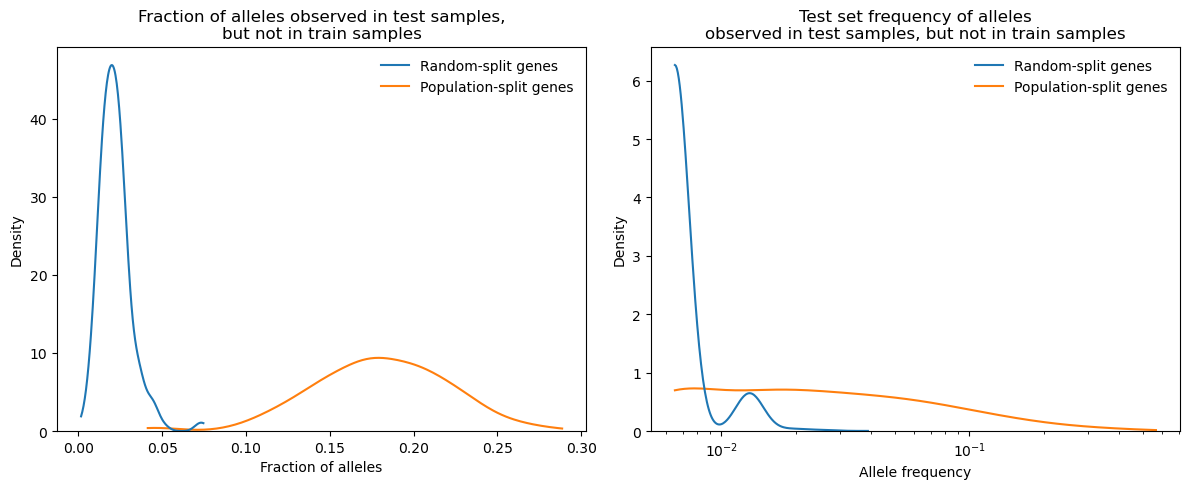

In [111]:
plot_results(
    unseen_variants_df,
    n_total_alleles_per_gene,
    gene_to_class_map,
    os.path.join(FIGURES_DIR, "alleles_unseen_in_train.pdf"),
)